Определить на сколько увеличится конверсия, сохранив значение неопределенности

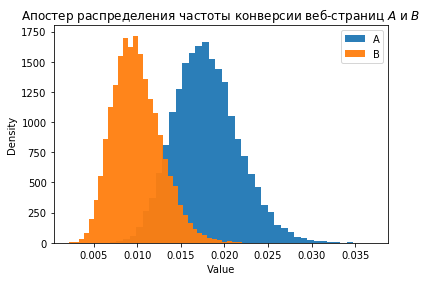

In [25]:
%matplotlib inline
import pymc3 as pm
import numpy as np
from scipy.stats import beta
from matplotlib import pyplot as plt

visitors_to_A = 1275
visitors_to_B = 1300

conversions_from_A = 22
conversions_from_B = 12

alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A,beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,beta_prior + visitors_to_B - conversions_from_B)

samples = 20000

samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype='stepfilled',alpha=.95, label=label, **kwargs)

_hist(samples_posterior_A, 'A')
_hist(samples_posterior_B, 'B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Апостер распределения частоты конверсии веб-страниц $А$ и $В$")
plt.legend();


Мы передали апостериорные распределения в функцию, вычисляющую попарно относительный рост.

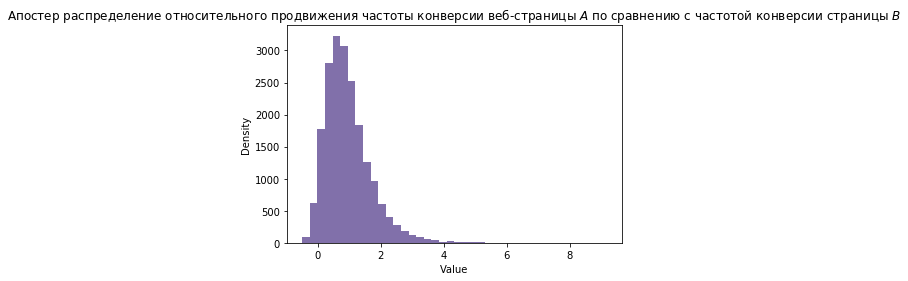

In [26]:
def relative_increase(a,b):
    return (a-b)/b
posterior_rel_increase = relative_increase(samples_posterior_A,
samples_posterior_B)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Апостер распределение относительного продвижения частоты конверсии веб-страницы $А$ по сравнению с частотой конверсии страницы $В$")
_hist(posterior_rel_increase, 'relative increase', color='#7A68A6');

In [27]:
print ('вероятность того, что относительный рост — 20 % или более, составляет 89 % ---',(posterior_rel_increase > 0.2).mean())
print ('вероятность того, что относительный рост — 50 % или более, составляет 72 % ---',(posterior_rel_increase > 0.5).mean())

вероятность того, что относительный рост — 20 % или более, составляет 89 % --- 0.88985
вероятность того, что относительный рост — 50 % или более, составляет 72 % --- 0.71645


не слишком вежливо вручать распределение кому-то, особенно бизнес-заказчику, который ожидает получить одно значение. Что же делать?

1. Вернуть среднее значение апостериорного распределения относительного роста. Мне этот вариант не слишком нравится.
На рис можно видеть длинный «хвост» возможных значений.
Это значит, что распределение асимметричное. При асимметричном распределении на сводные стат показатели слишком сильно влияет «хвост», следовательно, он окажется слишком сильно представлен в показателе и оценка фактического показателя относительного роста будет завышена.

2. Вернуть медианное значение апостериорного распределения относительного роста.
В свете предыдущего обсуждения медиана — более подходящий вариант. Она отличается большей робастностью к асимметричным распределениям. Однако мне кажется, что на практике медиана дает все еще слишком завышенное значение.

3. Вернуть процентиль (< 50 %) апостериорного распределения относительного роста. Например, вернуть 30-й процентиль распределения. У такого варианта есть два желательных для нас свойства. Первое: он математически эквивалентен применению функции потерь к апостериорному распределению относительного роста, штрафующей завышенные оценки сильнее, чем заниженные, вследствие чего оценка будет достаточно осторожной. Во-вторых, по мере получения в результате эксперимента все новых и новых данных апостериорное распределение относительного роста все более и более сужается, а значит, все процентили постепенно сходятся к одной точке.

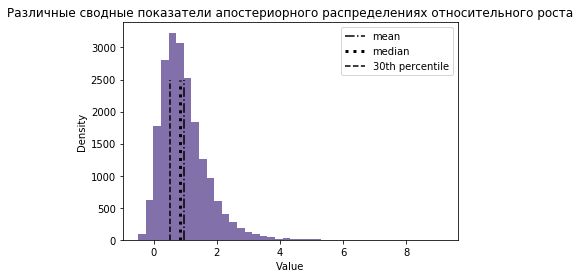

In [30]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)
_hist(posterior_rel_increase,'', color='#7A68A6');
plt.vlines(mean, 0, 2500, linestyles='-.', label='mean')
plt.vlines(median, 0, 2500, linestyles=':', label='median', lw=3)
plt.vlines(conservative_percentile, 0, 2500, linestyles='--',
label='30th percentile')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Различные сводные показатели апостериорного распределениях относительного роста")
plt.legend();